In [ ]:
# Sean Dougherty
# 03/15/2022
# this file reads in the output csv filed from agn_merger.py and does some preliminary visualization
# will later become a .py file for sharing and convinience

In [ ]:
# at the end of csv processing, we want a df with bins as columns and iterations as rows
# we want 3 of these: for pair AGN fraction, iso AGN fraction, and enhancement

In [1]:
# load libraries
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
from numpy import random
import matplotlib.pyplot as plt

import os

from time import sleep
from tqdm import tqdm

from multiprocessing import Pool, freeze_support, RLock

data_path = '/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/'
COSMOS_path = '/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/COSMOS/'

## Checking pair and control galaxy mass and redshift distributions

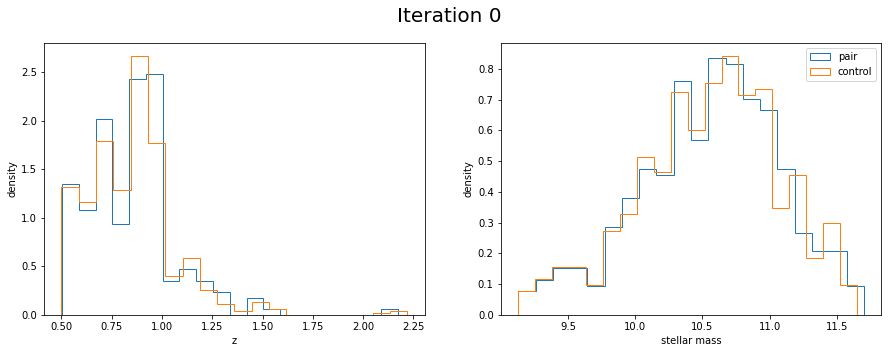

redshift medians:  0.8455615427997589 0.85149243
mass medians:  10.59985 10.59999


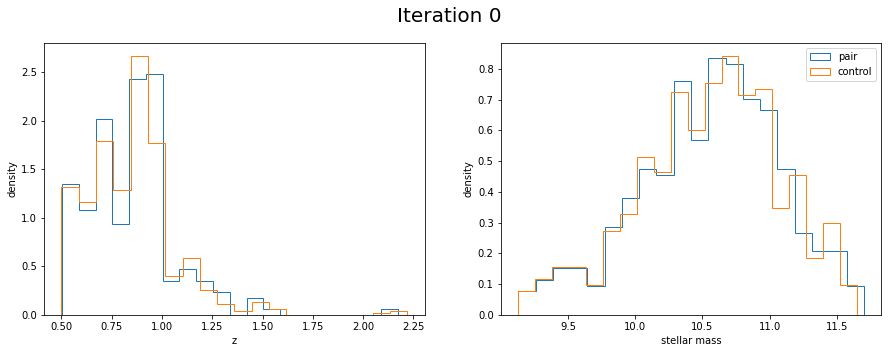

redshift medians:  0.8455615427997589 0.85149243
mass medians:  10.59985 10.59999


In [121]:
# do I want to do this by bin? or per iteration?
# probably best to just randomly choose 2 or 3 iterations to look at this for

#photo-specz_results/photo-specz_'

# photo-specz_5.csv
# data_path2 = 'photo-specz_results/q_zspec_gt_1/'
# data_path2 = 'photo-specz_results/q_zspec_ge_1_wAird/'
data_path2 = 'photo-specz_results/q_zspec_gt_1_wAird/'
# data_path2 = 'photoz_results/'
# data_path2 = 'specz_results/'


# COSMOS_path+'specz/'
# COSMOS_path+'photo-specz/'
# data_path+data_path2


# generate a 2 random integers to look at distributions
idx = random.randint(len(os.listdir(COSMOS_path+'specz/')), size=2)


# open each dataframe and plot distributions
for file_idx in idx:
    ran_df = pd.read_csv( COSMOS_path+'specz/'+(os.listdir(COSMOS_path+'specz/'))[file_idx] )
    ran_df = ran_df[ (ran_df['prime_drawn_M'] > 10) & (ran_df['prime_drawn_z'] < 3.0) ]#& 
                  # (ran_df['field'] == 'GDS')]
    
    # create arrays for distributions
    histp_z = np.concatenate( (np.array(ran_df['prime_drawn_z']), np.array(ran_df['partner_drawn_z'])), axis=0 )
    histp_M = np.concatenate( (np.array(ran_df['prime_drawn_M']), np.array(ran_df['partner_drawn_M'])), axis=0 )
    
    histc_z = np.concatenate( (np.array(ran_df['prime_control1_drawn_z']), np.array(ran_df['prime_control2_drawn_z']),
                               np.array(ran_df['partner_control1_drawn_z']), np.array(ran_df['partner_control2_drawn_z'])), axis=0 )
    histc_M = np.concatenate( (np.array(ran_df['prime_control1_drawn_M']), np.array(ran_df['prime_control2_drawn_M']),
                               np.array(ran_df['partner_control1_drawn_M']), np.array(ran_df['partner_control2_drawn_M'])), axis=0 )
    
    # make subplots to show mass and z distributions for pair and control galaxies
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    axs[0].hist(histp_z, bins=20, density=True, histtype='step')
    axs[0].hist(histc_z, bins=20, density=True, histtype='step')
    axs[0].set_xlabel('z')
    axs[0].set_ylabel('density')
    #axs[0].title['redshift']
    
    axs[1].hist(histp_M, bins=20, density=True, histtype='step', label='pair')
    axs[1].hist(histc_M, bins=20, density=True, histtype='step', label='control')
    axs[1].legend()
    axs[1].set_xlabel('stellar mass')
    axs[1].set_ylabel('density')
    
    fig.suptitle('Iteration {}'.format(file_idx), fontsize=20)
    
    #axs[1].title('iteration '+str(file_idx))
    plt.show()
    
    print( 'redshift medians: ', np.median(histp_z), np.nanmedian(histc_z) )
    print( 'mass medians: ', np.median(histp_M), np.nanmedian(histc_M) )
              

In [119]:
ran_df

,prime_index,partner_index,arc_sep,mass_ratio,dv,kpc_sep,prime_drawn_z,prime_drawn_M,prime_drawn_LX,partner_drawn_z,partner_drawn_M,partner_drawn_LX,prime_control1_ID,prime_control1_drawn_z,prime_control1_drawn_M,prime_control1_drawn_LX,prime_control2_ID,prime_control2_drawn_z,prime_control2_drawn_M,prime_control2_drawn_LX,partner_control1_ID,partner_control1_drawn_z,partner_control1_drawn_M,partner_control1_drawn_LX,partner_control2_ID,partner_control2_drawn_z,partner_control2_drawn_M,partner_control2_drawn_LX,field,prime_cat_ID,partner_cat_ID,prime_control1_cat_ID,prime_control2_cat_ID,partner_control1_cat_ID,partner_control2_cat_ID
0,32,28,4.051568,0.08521,-265.542125,27.518026,0.621200,10.99252,2.828459e+43,0.623000,10.90731,-1.209472e+59,9733,0.630542,11.00035,-1.241945e+59,9380,0.609271,10.98682,-1.151561e+59,11028,0.624456,10.90261,-1.215707e+59,2055,0.638401,10.90013,-1.276281e+59,COSMOS,225016,223197,1301671,1259621,1440262,614907
1,87,80,4.957932,0.74406,-103.383823,39.001632,0.932000,10.15381,-2.926746e+59,0.933000,9.40975,-2.933596e+59,6047,0.930900,10.15930,-2.919221e+59,3902,0.931030,10.14599,-2.920108e+59,10886,0.929746,9.41190,-2.911334e+59,8468,0.951385,9.41929,-3.061013e+59,COSMOS,255750,254413,959231,793204,1423129,1185737
2,122,125,2.801426,0.15020,113.237400,21.469307,0.852000,10.75020,-2.405767e+59,0.851000,10.60000,-2.399592e+59,771,0.850400,10.75000,-2.395892e+59,10285,0.850707,10.75146,-2.397787e+59,1611,0.848500,10.60136,-2.384193e+59,8590,0.855369,10.60062,-2.426630e+59,COSMOS,272291,273388,458242,1356945,563938,1194764
3,152,158,15.455748,0.16253,276.885010,96.994325,0.527217,10.59973,-8.374748e+58,0.525540,10.43720,-8.316227e+58,5254,0.526193,10.59999,-8.338967e+58,2969,0.521765,10.60000,-8.185323e+58,10825,0.519940,10.44824,-8.122470e+58,6872,0.517945,10.42691,-8.054046e+58,COSMOS,282266,283439,896125,713085,1415725,1037790
5,320,322,10.644903,0.51235,-140.116812,88.718014,1.244700,10.07854,-5.471102e+59,1.246600,9.56619,-5.489002e+59,3020,1.246000,10.09065,-5.483347e+59,5533,1.232600,10.07617,-5.357790e+59,7101,1.253170,9.57357,-5.551123e+59,6176,1.236000,9.56224,-5.389510e+59,COSMOS,351014,352490,717692,918433,1063824,970441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,10527,10535,3.564138,0.73472,972.284587,25.423498,0.697000,10.05559,-1.548375e+59,0.689838,9.32087,-1.513595e+59,4417,0.693214,10.05079,-1.529935e+59,10939,0.689337,10.05483,-1.511175e+59,9677,0.698472,9.31360,-1.555575e+59,6551,0.700742,9.31116,-1.566716e+59,COSMOS,1382933,1383286,829690,1429154,1294204,1003217
249,10706,10666,11.244696,0.50956,-446.733832,76.474136,0.623027,10.76729,-1.209590e+59,0.626064,10.25773,-1.222610e+59,7521,0.626938,10.77703,-1.226371e+59,10284,0.633399,10.75837,-1.254367e+59,3195,0.626140,10.25796,-1.222937e+59,3420,0.619032,10.26321,-1.192574e+59,COSMOS,1402464,1397584,1107860,1356694,733820,753024
251,10919,10921,2.393043,0.43370,-607.400108,18.272946,0.842200,10.27804,-2.345619e+59,0.847524,9.84434,-2.378194e+59,4501,0.849000,10.26624,-2.387269e+59,6859,0.843900,10.26316,-2.355995e+59,3762,0.847187,9.84179,-2.376125e+59,6557,0.848532,9.84710,-2.384388e+59,COSMOS,1426363,1426535,837029,1035872,783349,1003750
252,11079,11088,7.840796,0.25237,-401.305316,50.358486,0.551959,10.24558,-9.264340e+58,0.554468,9.99321,-9.357306e+58,3604,0.555100,10.24275,1.752978e+42,533,0.547898,10.24989,-9.114946e+58,11026,0.557670,9.99977,-9.476699e+58,1214,0.546221,9.99957,-9.053615e+58,COSMOS,1447471,1448892,769934,418995,1440110,510889


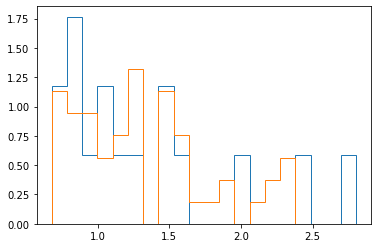

In [121]:
# test_df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/photoz_TEST.csv')
ran_df = ran_df[ ran_df['kpc_sep'] < 20 ]
pairz = np.concatenate( (np.array(ran_df['prime_drawn_z']), np.array(ran_df['partner_drawn_z'])), axis=0 )
isoz =  np.concatenate( (np.array(ran_df['prime_control1_drawn_z']), np.array(ran_df['prime_control2_drawn_z']),
                       np.array(ran_df['partner_control1_drawn_z']), np.array(ran_df['partner_control2_drawn_z'])), axis=0 )
pairm = np.concatenate( (np.array(ran_df['prime_drawn_M']), np.array(ran_df['partner_drawn_M'])), axis=0 )
isom =  np.concatenate( (np.array(ran_df['prime_control1_drawn_M']), np.array(ran_df['prime_control2_drawn_M']),
                       np.array(ran_df['partner_control1_drawn_M']), np.array(ran_df['partner_control2_drawn_M'])), axis=0 )
x, bins, patches = plt.hist(pairz, bins=20, density=True, histtype='step')
plt.hist(isoz, bins=bins, density=True, histtype='step')
plt.show()

In [ ]:
ran_df2 = ran_df[ (ran_df['prime_drawn_LX'] > 42) ]
ran_df3 = ran_df[ (ran_df['partner_drawn_LX'] > 42) ]

ran_df4 = ran_df[ (ran_df['prime_control1_drawn_LX'] > 42) ]
ran_df5 = ran_df[ (ran_df['prime_control2_drawn_LX'] > 42) ]
ran_df6 = ran_df[ (ran_df['partner_control1_drawn_LX'] > 42) ]
ran_df7 = ran_df[ (ran_df['partner_control2_drawn_LX'] > 42) ]

# print(ran_df2['prime_index'])
# print(ran_df3['partner_index'])
# print(ran_df4['prime_control1_ID'])
# print(ran_df5['prime_control2_ID'])
# print(ran_df6['partner_control1_ID'])
# print(ran_df7['partner_control2_ID'])


## Pair/Control z and mass distributions over all iteration

In [ ]:
# loop through all files in directory
# keep appending the mass and redshift values -> in each bin though
# take median / mean at the end
# compliment with some kind of LX distrubutions at different mass or redshifts

In [223]:
# get the bin information -> only really need 'bins'
max_dist=150
n_bins=6
bins, bin_all_pairfrac, bin_all_isofrac, bin_AGN_count, bin_gal_count = make_bins(max_dist=max_dist, n_bins=n_bins)

# define X-ray luminosity AGN limit
LX_AGN = 10**42

# create dictionaries for isolated / control mass / z arrays
im_dict = {}
iz_dict = {}
pm_dict = {}
pz_dict = {}

# AGN frequency ideally peaks around z=2 -> are there more AGN in galaxies at higher redshifts?
# to test this, let's keep track of (z, LX) across all iterations -> all together now
AGN_z = []
AGN_LX = []

# loop throug the bins to create empty lists to append to
for rnge in bins:
    im_dict[bins[rnge]] = []
    iz_dict[bins[rnge]] = []
    pm_dict[bins[rnge]] = []
    pz_dict[bins[rnge]] = []
    
# agn_merger.py outputs:
# data_path2 = 'photo-specz_results/q_zspec_gt_1/'             # data_path+data_path2
# data_path2 = 'photo-specz_results/q_zspec_ge_1_wAird/'     # COSMOS_path+'photo-specz/'
# data_path2 = 'photo-specz_results/q_zspec_gt_1_wAird/'     # COSMOS_path+'photoz/kpc150/'
# data_path2 = 'photo-specz_results/kpc100/'
# data_path2 = 'photoz_results/kpc100/'
# data_path2 = 'photoz_results/'
data_path2 = 'specz_results/kpc150/'

# read through all the iteration files
for file in tqdm(os.listdir(data_path+data_path2), miniters=10):
    it_df = pd.read_csv(data_path+data_path2+file)
    it_df = it_df[ (it_df['prime_drawn_M'] > 10) & (it_df['prime_drawn_z'] < 3.0) ]#& (it_df['field'] != 'GDN') & # &
               # (it_df['field'] != 'COS') ]#(it_df['mass_ratio'] <= 0.40)]
        
    # append AGN z and LX values
    AGN_z.append( np.array( it_df.loc[it_df['prime_drawn_LX'] > LX_AGN, 'prime_drawn_z'] ) )
    AGN_z.append( np.array( it_df.loc[it_df['partner_drawn_LX'] > LX_AGN, 'partner_drawn_z'] ) )
    AGN_z.append( np.array( it_df.loc[it_df['prime_control1_drawn_LX'] > LX_AGN, 'prime_control1_drawn_z'] ) )
    AGN_z.append( np.array( it_df.loc[it_df['prime_control2_drawn_LX'] > LX_AGN, 'prime_control2_drawn_z'] ) )
    AGN_z.append( np.array( it_df.loc[it_df['partner_control1_drawn_LX'] > LX_AGN, 'partner_control1_drawn_z'] ) )
    AGN_z.append( np.array( it_df.loc[it_df['partner_control2_drawn_LX'] > LX_AGN, 'partner_control2_drawn_z'] ) )
    AGN_LX.append( np.array( it_df.loc[it_df['prime_drawn_LX'] > LX_AGN, 'prime_drawn_LX'] ) )
    AGN_LX.append( np.array( it_df.loc[it_df['partner_drawn_LX'] > LX_AGN, 'partner_drawn_LX'] ) )
    AGN_LX.append( np.array( it_df.loc[it_df['prime_control1_drawn_LX'] > LX_AGN, 'prime_control1_drawn_LX'] ) )
    AGN_LX.append( np.array( it_df.loc[it_df['prime_control2_drawn_LX'] > LX_AGN, 'prime_control2_drawn_LX'] ) )
    AGN_LX.append( np.array( it_df.loc[it_df['partner_control1_drawn_LX'] > LX_AGN, 'partner_control1_drawn_LX'] ) )
    AGN_LX.append( np.array( it_df.loc[it_df['partner_control2_drawn_LX'] > LX_AGN, 'partner_control2_drawn_LX'] ) )
                 
    
    # separate pairs into bins
    for rnge in bins:
        # get bin ranges from bins dictionary entries
        info = bins[rnge].split('-')
        low = float(info[0])
        high = float(info[1])
        
        # sort into bins
        bin_df = it_df[ (it_df['kpc_sep'] > low) & (it_df['kpc_sep'] <= high) ]
        
        # append all mass and z values to appropriate dictionaries
        im_dict[bins[rnge]].append( np.concatenate((np.array(bin_df['prime_control1_drawn_M']), np.array(bin_df['prime_control2_drawn_M']),
                                   np.array(bin_df['partner_control1_drawn_M']), np.array(bin_df['partner_control2_drawn_M'])), axis=0) )
        iz_dict[bins[rnge]].append( np.concatenate((np.array(bin_df['prime_control1_drawn_z']), np.array(bin_df['prime_control2_drawn_z']),
                                   np.array(bin_df['partner_control1_drawn_z']), np.array(bin_df['partner_control2_drawn_z'])), axis=0) )
        pm_dict[bins[rnge]].append( np.concatenate((np.array(bin_df['prime_drawn_M']),
                                   np.array(bin_df['partner_drawn_M'])), axis=0) )
        pz_dict[bins[rnge]].append( np.concatenate((np.array(bin_df['prime_drawn_z']),
                                   np.array(bin_df['partner_drawn_z'])), axis=0) )


100%|██████████| 1/1 [00:00<00:00, 47.41it/s]


In [224]:
# change from list of arrays to arrays
for rnge in bins:
    im_dict[bins[rnge]] = np.concatenate(im_dict[bins[rnge]]).ravel()
    iz_dict[bins[rnge]] = np.concatenate(iz_dict[bins[rnge]]).ravel()
    pm_dict[bins[rnge]] = np.concatenate(pm_dict[bins[rnge]]).ravel()
    pz_dict[bins[rnge]] = np.concatenate(pz_dict[bins[rnge]]).ravel()
    
    # remove nans from control arrays
    im_dict[bins[rnge]] = im_dict[bins[rnge]][~np.isnan(im_dict[bins[rnge]])]
    iz_dict[bins[rnge]] = iz_dict[bins[rnge]][~np.isnan(iz_dict[bins[rnge]])]

In [225]:
# prepare for violin plots
pmass = [ (pm_dict[col]) for col in pm_dict ]
pz = [ (pz_dict[col]) for col in pz_dict ]
imass = [ (im_dict[col]) for col in im_dict ]
iz = [ (iz_dict[col]) for col in iz_dict ]

# make position vector
kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

# define violin plot width
vwidth = float((bins['0'].split('-'))[1]) - float((bins['0'].split('-'))[0])

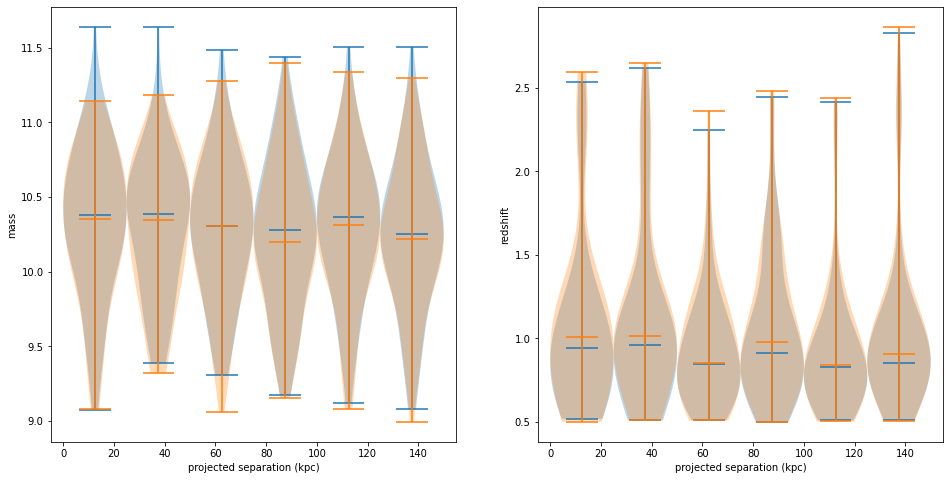

In [226]:
# make violin plots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axs[0].violinplot(pmass, kpc_meds, points=100, widths=vwidth, showmeans=False,
                     showextrema=True, showmedians=True, bw_method=0.5)
axs[0].violinplot(imass, kpc_meds, points=100, widths=vwidth, showmeans=False,
                     showextrema=True, showmedians=True, bw_method=0.5)
# axs[0].set_title('Results', fontsize=20)
axs[0].axis(xmin=-5,xmax=155)
axs[0].set_xlabel('projected separation (kpc)')
axs[0].set_ylabel('mass')

axs[1].violinplot(pz, kpc_meds, points=100, widths=vwidth, showmeans=False,
                     showextrema=True, showmedians=True, bw_method=0.5)
axs[1].violinplot(iz, kpc_meds, points=100, widths=vwidth, showmeans=False,
                     showextrema=True, showmedians=True, bw_method=0.5)
axs[1].axis(xmin=-5,xmax=155)
axs[1].set_xlabel('projected separation (kpc)')
axs[1].set_ylabel('redshift')

plt.show()

In [227]:
# prepare for AGN vs z plot:
AGN_z = np.concatenate(AGN_z).ravel()
AGN_LX = np.concatenate(AGN_LX).ravel()

In [228]:
# plt.hist(AGN_LX, bins=100)

In [229]:
# it_df.loc[it_df['prime_drawn_LX'] > 0 ]
len(AGN_LX)

193

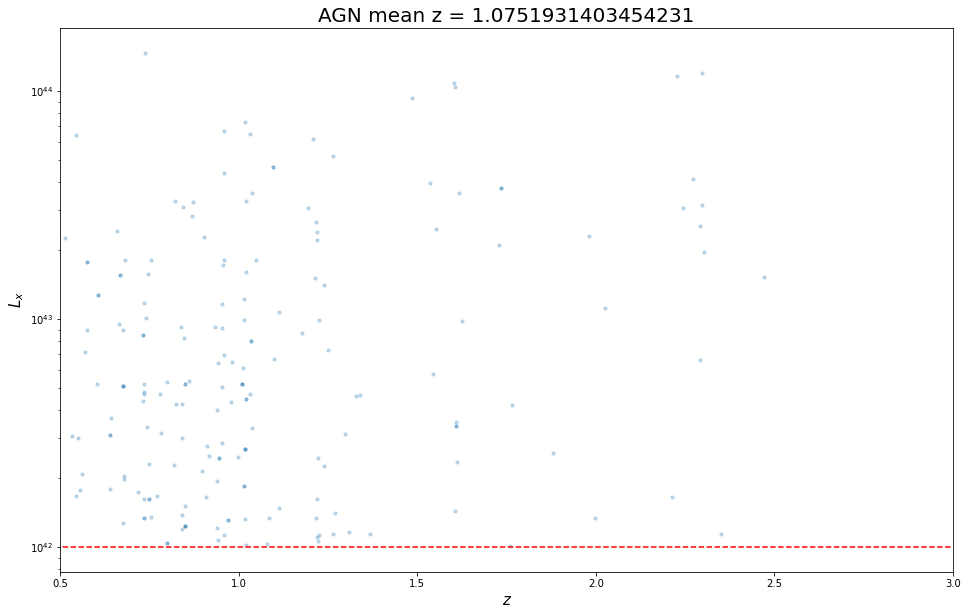

In [230]:
# plot AGN vs z
fig = plt.figure(figsize=(16,10))
plt.scatter(AGN_z, AGN_LX, s=10, alpha=0.25)
plt.yscale('log')
plt.plot((0, 3.5),(10**42,10**42), color='r', linestyle='--')
plt.xlim(0.5,3.0)
plt.title('AGN mean z = ' + str(np.mean(AGN_z[np.where(AGN_LX > 10**42)])), fontsize=20)
plt.xlabel('$z$', fontsize=15)
plt.ylabel('$L_x$', fontsize=15)
plt.show()

## Galaxy property checks

In [ ]:
# For a random single iteration, plot the distribution of mass in each bin

# photo-specz_5.csv
# data_path2 = 'photo-specz_results/q_zspec_gt_1/'
# data_path2 = 'photo-specz_results/q_zspec_ge_1_wAird/'
# data_path2 = 'photo-specz_results/q_zspec_gt_1_wAird/'
data_path2 = 'photoz_results/'


# generate a 2 random integers to look at distributions
idx = random.randint(len(os.listdir(COSMOS_path+'photo-specz/')))
# generate bins
max_dist = 150
n_bins = 8
bins, bin_all_pairfrac, bin_all_isofrac, bin_AGN_count, bin_gal_count = make_bins(max_dist=max_dist, n_bins=n_bins)

# create dictionaries to store redshift and mass distributions
bin_AGN = {}
bin_pairfrac_mass = {}
bin_isofrac_mass = {}
bin_pairfrac_z = {}
bin_isofrac_z = {}

bin_pid = {}
bin_cid = {}

it_df = pd.read_csv( data_path+data_path2+(os.listdir(data_path+data_path2))[idx] )

# it_df = pd.read_csv(data_path+'photoz_results/'+file)
it_df = it_df[ (it_df['field'] != 'GDS') & (it_df['prime_drawn_M'] > 9.5)  ]
    
# separate pairs into bins
for rnge in bins:
    # get bin ranges from bins dictionary entries
    info = bins[rnge].split('-')
    low = float(info[0])
    high = float(info[1])

    # sort into bins
    bin_df = it_df[ (it_df['kpc_sep'] > low) & (it_df['kpc_sep'] <= high) ]

    # print(len(bin_df[ (bin_df['prime_drawn_LX'] > 42) ]) , bin_df['prime_drawn_LX'].count())
    # print(len(bin_df[ (bin_df['partner_drawn_LX'] > 42) ]) , bin_df['partner_drawn_LX'].count())
    # print('-----')
    # print(len(bin_df[ (bin_df['prime_control1_drawn_LX'] > 42) ]), bin_df['prime_control1_drawn_LX'].count())
    # print(len(bin_df[ (bin_df['prime_control2_drawn_LX'] > 42) ]), bin_df['prime_control2_drawn_LX'].count())
    # print(len(bin_df[ (bin_df['partner_control1_drawn_LX'] > 42) ]), bin_df['partner_control1_drawn_LX'].count())
    # print(len(bin_df[ (bin_df['partner_control2_drawn_LX'] > 42) ]), bin_df['partner_control2_drawn_LX'].count())
    # print('----------------------')
    
    # get pair distributions for mass and redshift in each bin
    bin_pairfrac_mass['pair_mass_in_'+rnge] = np.concatenate( (np.array(bin_df.loc[:, 'prime_drawn_M']), 
                                                               np.array(bin_df.loc[:, 'partner_drawn_M'])), axis=0 )
    bin_pairfrac_z['pair_z_in_'+rnge] = np.concatenate( (np.array(bin_df.loc[:, 'prime_drawn_z']), 
                                                               np.array(bin_df.loc[:, 'partner_drawn_z'])), axis=0 )
    bin_isofrac_mass['iso_mass_in_'+rnge] = np.concatenate( (np.array(bin_df.loc[:, 'prime_control1_drawn_M']), 
                                                               np.array(bin_df.loc[:, 'prime_control2_drawn_M']),
                                                           np.array(bin_df.loc[:, 'partner_control1_drawn_M']),
                                                           np.array(bin_df.loc[:, 'partner_control2_drawn_M'])), axis=0 )
    bin_isofrac_z['iso_z_in_'+rnge] = np.concatenate( (np.array(bin_df.loc[:, 'prime_control1_drawn_z']), 
                                                               np.array(bin_df.loc[:, 'prime_control2_drawn_z']),
                                                           np.array(bin_df.loc[:, 'partner_control1_drawn_z']),
                                                           np.array(bin_df.loc[:, 'partner_control2_drawn_z'])), axis=0 )
    bin_pid['pid_'+rnge] = np.concatenate( (np.array(bin_df.loc[:, 'prime_index']), 
                                                               np.array(bin_df.loc[:, 'partner_index'])), axis=0 )
    bin_cid['cid_'+rnge] = np.concatenate( (np.array(bin_df.loc[:, 'prime_control1_ID']), 
                                                               np.array(bin_df.loc[:, 'prime_control2_ID']),
                                                           np.array(bin_df.loc[:, 'partner_control1_ID']),
                                                           np.array(bin_df.loc[:, 'partner_control2_ID'])), axis=0 )


In [ ]:
# aa = np.array(bin_df.loc[bin_df['field'] == 'GDS', 'prime_index'])
# print(aa)

# bb = np.array(bin_df.loc[bin_df['field'] == 'GDS', 'prime_control1_ID'])

# cc = np.array(bin_df.loc[bin_df['field'] == 'GDS', 'partner_control1_ID'])
# # check for duplicate indices
# for idx in aa:
#     if idx in bb or idx in cc:
#         print('oops')

In [ ]:
pmass = [ (bin_pairfrac_mass[col]) for col in bin_pairfrac_mass]
pz = [ (bin_pairfrac_z[col]) for col in bin_pairfrac_z]
imass = [ (bin_isofrac_mass[col])[~np.isnan(bin_isofrac_mass[col])] for col in bin_isofrac_mass]
iz = [ (bin_isofrac_z[col])[~np.isnan(bin_isofrac_z[col])] for col in bin_isofrac_z]

# make position vector
kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

In [ ]:
# make violin plots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axs[0].violinplot(pmass, kpc_meds, points=100, widths=vwidth, showmeans=False,
                     showextrema=True, showmedians=True, bw_method=0.5)
axs[0].violinplot(imass, kpc_meds, points=100, widths=vwidth, showmeans=False,
                     showextrema=True, showmedians=True, bw_method=0.5)
# axs[0].set_title('Results', fontsize=20)
axs[0].axis(xmin=-5,xmax=105)
axs[0].set_xlabel('projected separation (kpc)')
axs[0].set_ylabel('mass')

axs[1].violinplot(pz, kpc_meds, points=100, widths=vwidth, showmeans=False,
                     showextrema=True, showmedians=True, bw_method=0.5)
axs[1].violinplot(iz, kpc_meds, points=100, widths=vwidth, showmeans=False,
                     showextrema=True, showmedians=True, bw_method=0.5)
axs[1].axis(xmin=-5,xmax=105)
axs[1].set_xlabel('projected separation (kpc)')
axs[1].set_ylabel('redshift')

plt.show()


## Calculate AGN fractions

In [203]:
# create bins
max_dist = 150
n_bins = 6
bins, bin_all_pairfrac, bin_all_isofrac, bin_AGN_count, bin_gal_count = make_bins(max_dist=max_dist, n_bins=n_bins)

# define X-ray luminosity AGN limit
LX_AGN = 10**42

# create dictionaries to store AGN fractions
bin_AGN = {}
bin_pairfrac = {}
bin_isofrac = {}

# may want to reorganize make_bins to do this here... doesn't really matter but should at least be consistent
bin_isoAGN_count = {}
bin_isogal_count = {}
for rnge in bins:
    bin_isoAGN_count[bins[rnge]] = []
    bin_isogal_count[bins[rnge]] = []

# data_path2 = 'photo-specz_results/q_zspec_gt_1/'
# data_path2 = 'photo-specz_results/q_zspec_ge_1_wAird/'        # data_path+data_path2
#data_path2 = 'photo-specz_results/q_zspec_gt_1_wAird/'          # COSMOS_path+'photo-specz/'
# data_path2 = 'photoz_results/'                                # COSMOS_path+'specz/'
data_path2 = 'specz_results/kpc150/'                                 # COSMOS_path+'photoz/kpc150/'
# data_path2 = 'photo-specz_results/kpc100/'                      # COSMOS_path+'photoz/kpc100/'
# data_path2 = 'photoz_results/kpc100/'



# read through all the iteration files
for file in tqdm(os.listdir(data_path+data_path2), miniters=10):
    it_df = pd.read_csv(data_path+data_path2+file)
    it_df = it_df[ (it_df['prime_drawn_M'] > 10) & (it_df['prime_drawn_z'] < 3.0) ]#& (it_df['field'] == 'UDS') ]
               #(it_df['field'] != 'COS') ] #(it_df['mass_ratio'] >= 0.40)]
        
    # separate pairs into bins
    for rnge in bins:
        # get bin ranges from bins dictionary entries
        info = bins[rnge].split('-')
        low = float(info[0])
        high = float(info[1])
        
        # sort into bins
        bin_df = it_df[ (it_df['kpc_sep'] > low) & (it_df['kpc_sep'] <= high) ]
        
        
        # calculate the AGN fraction in that bin and append it to same calculation accross iteration
        bin_pairfrac[bins[rnge]] = ((  len(bin_df[ (bin_df['prime_drawn_LX'] > LX_AGN) ]) +
                                             len(bin_df[ (bin_df['partner_drawn_LX'] > LX_AGN) ])
                                            ) /
                                            (  bin_df['prime_drawn_LX'].count() +
                                             bin_df['partner_drawn_LX'].count()
                                            ))
        bin_all_pairfrac[bins[rnge]].append(bin_pairfrac[bins[rnge]])

        
        bin_isofrac[bins[rnge]] = ((  len(bin_df[ (bin_df['prime_control1_drawn_LX'] > LX_AGN) ] ) +
                                            len(bin_df[ (bin_df['prime_control2_drawn_LX'] > LX_AGN) ]) +
                                            len(bin_df[ (bin_df['partner_control1_drawn_LX'] > LX_AGN) ]) +
                                            len(bin_df[ (bin_df['partner_control2_drawn_LX'] > LX_AGN) ]) 
                                           ) /
                                            (  bin_df['prime_control1_drawn_LX'].count() +
                                             bin_df['prime_control2_drawn_LX'].count() +
                                             bin_df['partner_control1_drawn_LX'].count() +
                                             bin_df['partner_control2_drawn_LX'].count() ))
        bin_all_isofrac[bins[rnge]].append(bin_isofrac[bins[rnge]])
        
        # store simple counts
        bin_AGN_count[bins[rnge]].append(len(bin_df[ (bin_df['prime_drawn_LX'] > LX_AGN) ]) +
                                             len(bin_df[ (bin_df['partner_drawn_LX'] > LX_AGN) ]))
        
        bin_gal_count[bins[rnge]].append(bin_df['prime_drawn_LX'].count() +
                                             bin_df['partner_drawn_LX'].count())
        
        bin_isoAGN_count[bins[rnge]].append(  len(bin_df[ (bin_df['prime_control1_drawn_LX'] > LX_AGN) ] ) +
                                            len(bin_df[ (bin_df['prime_control2_drawn_LX'] > LX_AGN) ]) +
                                            len(bin_df[ (bin_df['partner_control1_drawn_LX'] > LX_AGN) ]) +
                                            len(bin_df[ (bin_df['partner_control2_drawn_LX'] > LX_AGN) ]) )
        
        bin_isogal_count[bins[rnge]].append(  bin_df['prime_control1_drawn_LX'].count() +
                                             bin_df['prime_control2_drawn_LX'].count() +
                                             bin_df['partner_control1_drawn_LX'].count() +
                                             bin_df['partner_control2_drawn_LX'].count() )

100%|██████████| 1/1 [00:00<00:00, 13.39it/s]


In [204]:
# len(it_df[it_df['field']=='GDN']) # I get more spec-z pairs from GDN then I do GDS, opposite for Shah...
# # what am I missing....
# bin_isoAGN_count['0.0-12.5']

In [205]:
def make_bins(max_dist=100, n_bins=10):

    bin_all_AGNfrac = {}
    bin_all_isofrac = {}
    
    # create dictionaries to store AGN and pair galaxy counts -> just for paried galaxies (controls later)
    bin_AGN_count = {}
    bin_gal_count = {}

    # create bin sizes
    all_bins = {}
    for bn in range(0, n_bins):
        # define limits for each bin
        all_bins[str(bn)] = str((max_dist/n_bins)*bn)+'-'+str((max_dist/n_bins)+(max_dist/n_bins)*bn)
        # define empty lists to later append AGN fractions to
        bin_all_AGNfrac[all_bins[str(bn)]] = []
        bin_all_isofrac[all_bins[str(bn)]] = []
        bin_AGN_count[all_bins[str(bn)]] = []
        bin_gal_count[all_bins[str(bn)]] = []
        
    
    return all_bins, bin_all_AGNfrac, bin_all_isofrac, bin_AGN_count, bin_gal_count

In [206]:
# create dataframes from the dictionaries:
pAGNf_df = pd.DataFrame.from_dict(bin_all_pairfrac)
iAGNf_df = pd.DataFrame.from_dict(bin_all_isofrac)

In [207]:
pAGNf_df.describe()

,0.0-25.0,25.0-50.0,50.0-75.0,75.0-100.0,100.0-125.0,125.0-150.0
count,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,0.068966,0.135593,0.061404,0.119718,0.054348,0.073034
std,NaN,NaN,NaN,NaN,NaN,NaN
min,0.068966,0.135593,0.061404,0.119718,0.054348,0.073034
25%,0.068966,0.135593,0.061404,0.119718,0.054348,0.073034
50%,0.068966,0.135593,0.061404,0.119718,0.054348,0.073034
75%,0.068966,0.135593,0.061404,0.119718,0.054348,0.073034
max,0.068966,0.135593,0.061404,0.119718,0.054348,0.073034


In [208]:
iAGNf_df.describe()

,0.0-25.0,25.0-50.0,50.0-75.0,75.0-100.0,100.0-125.0,125.0-150.0
count,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,0.074468,0.099502,0.091371,0.063241,0.072555,0.101307
std,NaN,NaN,NaN,NaN,NaN,NaN
min,0.074468,0.099502,0.091371,0.063241,0.072555,0.101307
25%,0.074468,0.099502,0.091371,0.063241,0.072555,0.101307
50%,0.074468,0.099502,0.091371,0.063241,0.072555,0.101307
75%,0.074468,0.099502,0.091371,0.063241,0.072555,0.101307
max,0.074468,0.099502,0.091371,0.063241,0.072555,0.101307


In [209]:
### photo ###
#0.030469	0.017197	0.014310	0.017071	0.017050	0.012333	0.014314	0.011376
#0.030444	0.016769	0.014832	0.017431	0.018136	0.011767	0.014715	0.011397
### photo+spec ###
#0.024890	0.015904	0.012903	0.014925	0.016148	0.011903	0.013837	0.010741
#0.023732	0.014565	0.013229	0.016505	0.016001	0.011962	0.014264	0.010781

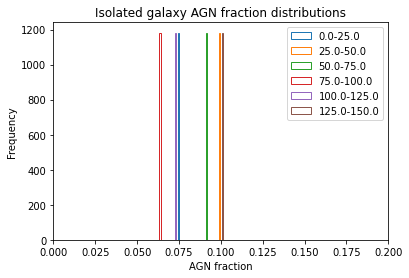

In [210]:
# plot distributions
iAGNf_df.plot.hist(bins=45, histtype='step', density=True)

plt.title('Isolated galaxy AGN fraction distributions')
plt.xlabel('AGN fraction')
plt.xlim(0, 0.2)
plt.show()

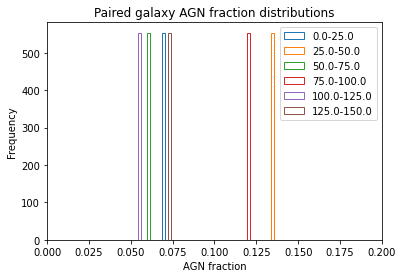

In [211]:
pAGNf_df.plot.hist(bins=45, histtype='step', density=True)
plt.xlim(0, 0.20)
plt.title('Paired galaxy AGN fraction distributions')
plt.xlabel('AGN fraction')
plt.show()

In [212]:
# make AGN fraction vectors
pdata = [pAGNf_df[col] for col in pAGNf_df]
idata = [iAGNf_df[col] for col in pAGNf_df]

# make position vector
kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

# define violin plot width
vwidth = float((bins['0'].split('-'))[1]) - float((bins['0'].split('-'))[0])

# make an AGN enhancment vector
# quick way to get rid of dividing by 0 issue, will need to address later

for j in range(0,len(idata)):
    for k in range(0, len(idata[j])):
        if idata[j][k] == 0:
            idata[j][k] = 1000
            
for j in range(0,len(idata)):
    for k in range(0, len(idata[j])):
        if idata[j][k] == 1000:            
            idata[j][k] = min(idata[j])
            print('here')
        


AGN_enh = [(pdata[i] / idata[i]) for i in range(0, len(pdata))]

# should make some dynamic vector in case I want to increase pair sample out to 150 kpc or something

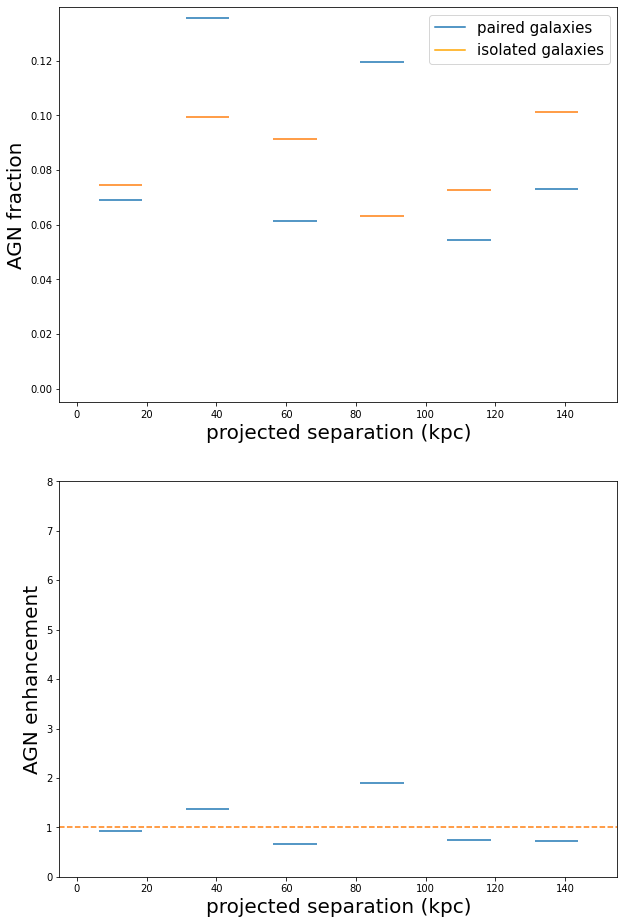

In [213]:
# make violin plots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 16))
axs[0].violinplot(pdata, kpc_meds, points=100, widths=vwidth, showmeans=False,
                     showextrema=False, showmedians=True, bw_method=0.5)
axs[0].violinplot(idata, kpc_meds, points=100, widths=vwidth, showmeans=False,
                     showextrema=False, showmedians=True, bw_method=0.5)
# axs[0].set_title('Results', fontsize=20)
axs[0].axis(xmin=-5,xmax=155)
axs[0].axis(ymin=-0.005)
axs[0].set_xlabel('projected separation (kpc)', fontsize=20)
axs[0].set_ylabel('AGN fraction', fontsize=20)
axs[0].plot([-10,-10], color='#1f77b4', label='paired galaxies')
axs[0].plot([-10,-10], color='orange', label='isolated galaxies')
axs[0].legend(fontsize=15)

axs[1].violinplot(AGN_enh, kpc_meds, points=100, widths=vwidth, showmeans=False,
                     showextrema=False, showmedians=True, bw_method=0.5)
axs[1].plot([-5,155], [1,1], linestyle='--')
axs[1].axis(xmin=-5,xmax=155)
axs[1].axis(ymin=0, ymax=8)
axs[1].set_xlabel('projected separation (kpc)', fontsize=20)
axs[1].set_ylabel('AGN enhancement', fontsize=20)

plt.show()



In [214]:
# show average out counts from the bins and output as a simple df
# copy the bin_gal_count distributions to use later
bin_gal_count_copy = bin_gal_count.copy()
for rnge in bins:
    bin_AGN_count[str(bins[rnge])] = [np.mean(bin_AGN_count[str(bins[rnge])])]
    bin_gal_count[str(bins[rnge])] = [np.mean(bin_gal_count[str(bins[rnge])])]
    bin_isoAGN_count[str(bins[rnge])] = [np.mean(bin_isoAGN_count[str(bins[rnge])])]
    bin_isogal_count[str(bins[rnge])] = [np.mean(bin_isogal_count[str(bins[rnge])])]
# print(bin_gal_count)
AGN_count_df = pd.DataFrame.from_dict(bin_AGN_count)
gal_count_df = pd.DataFrame.from_dict(bin_gal_count)
isoAGN_count_df = pd.DataFrame.from_dict(bin_isoAGN_count)
isogal_count_df = pd.DataFrame.from_dict(bin_isogal_count)
df = pd.concat([AGN_count_df,gal_count_df, isoAGN_count_df,isogal_count_df], ignore_index = True, axis=0)
df.rename(index={0: 'mean pair AGN count', 1: 'mean paired gals count',
                2: 'mean iso AGN count', 3: 'mean iso gals count'})


,0.0-25.0,25.0-50.0,50.0-75.0,75.0-100.0,100.0-125.0,125.0-150.0
mean pair AGN count,8.0,16.0,7.0,17.0,10.0,13.0
mean paired gals count,116.0,118.0,114.0,142.0,184.0,178.0
mean iso AGN count,14.0,20.0,18.0,16.0,23.0,31.0
mean iso gals count,188.0,201.0,197.0,253.0,317.0,306.0


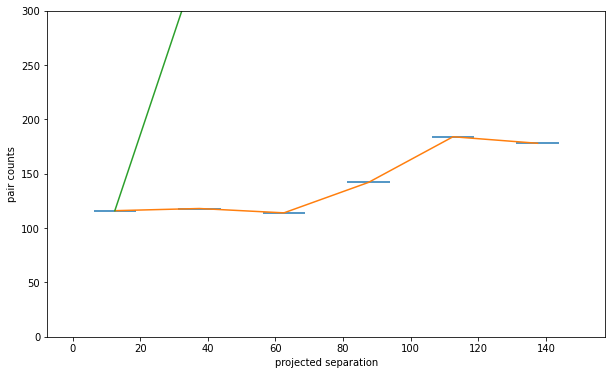

,Unnamed: 0,prime_index,partner_index,arc_sep,mass_ratio,dv,kpc_sep,prime_drawn_z,prime_drawn_M,prime_drawn_LX,partner_drawn_z,partner_drawn_M,partner_drawn_LX,prime_control1_ID,prime_control1_drawn_z,prime_control1_drawn_M,prime_control1_drawn_LX,prime_control2_ID,prime_control2_drawn_z,prime_control2_drawn_M,prime_control2_drawn_LX,partner_control1_ID,partner_control1_drawn_z,partner_control1_drawn_M,partner_control1_drawn_LX,partner_control2_ID,partner_control2_drawn_z,partner_control2_drawn_M,partner_control2_drawn_LX,prime_cflag1,prime_cflag2,partner_cflag1,partner_cflag2,field,prime_cat_ID,partner_cat_ID,prime_control1_cat_ID,prime_control2_cat_ID,partner_control1_cat_ID,partner_control2_cat_ID
0,7,8,11,18.019655,0.080000,-325.774025,122.086160,0.617800,10.640000,7.814958e+41,0.620000,10.560000,-1.196686e+59,1684.0,0.605430,10.640000,-1.135634e+59,188.0,0.660080,10.650000,-1.373634e+59,1432.0,0.536810,10.280000,-8.713802e+58,1718.0,0.523725,10.270000,-8.253153e+58,0,0,0,0,GDS,125,171,19896.0,2750.0,17171.0,20468.0
1,15,14,19,10.085403,0.360000,473.035185,74.886174,0.774970,10.130000,-1.954622e+59,0.771150,9.770000,-1.933538e+59,594.0,0.735950,10.110000,-1.744988e+59,1297.0,0.737500,10.100000,-1.753074e+59,1599.0,0.861200,9.760000,-2.462961e+59,1907.0,0.853670,9.710000,-2.416096e+59,0,0,0,0,GDS,236,285,8760.0,16011.0,18804.0,23597.0
10,323,155,143,15.354721,0.010000,-363.266298,108.781758,0.685345,10.580000,-1.491993e+59,0.688000,10.570000,-1.504737e+59,677.0,0.675055,10.550000,-1.443149e+59,267.0,0.706205,10.540000,-1.593703e+59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,2,2,GDS,2178,1972,9926.0,3827.0,NaN,NaN
16,384,190,195,7.515229,0.380000,145.935337,61.447424,1.103000,10.500000,6.187344e+41,1.101300,10.120000,-4.204612e+59,1527.0,1.097000,10.470000,-4.169228e+59,465.0,1.094000,10.460000,-4.144630e+59,1446.0,1.095000,10.140000,-4.152821e+59,532.0,1.139500,10.090000,-4.525617e+59,0,0,0,0,GDS,2795,2840,18048.0,7219.0,17245.0,8040.0
21,445,208,222,9.864222,0.230000,41.863267,68.152832,0.645727,10.050000,-1.308744e+59,0.645435,9.820000,-1.307443e+59,1785.0,0.668200,9.990000,-1.411098e+59,276.0,0.678700,10.110000,-1.460351e+59,450.0,0.533875,9.840000,-8.609280e+58,92.0,0.531200,9.860000,-8.514621e+58,0,0,0,0,GDS,2987,3184,21650.0,3997.0,6946.0,1188.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,187,288,291,2.552362,0.221849,109.876074,20.635473,1.043200,10.505150,-3.739362e+59,1.042000,10.283301,-3.730046e+59,77.0,1.038700,10.495544,-3.704488e+59,91.0,1.066200,10.475671,-3.920216e+59,281.0,1.030600,10.178977,-3.642137e+59,31.0,1.194500,10.262451,3.059876e+43,0,0,0,0,UDS,20876,21047,6436.0,7346.0,20031.0,3452.0
909,188,288,293,12.492418,0.352862,-100.593564,100.999346,1.043200,10.505150,-3.739362e+59,1.044300,10.152288,-3.747912e+59,297.0,1.009500,10.622214,-3.482264e+59,234.0,0.919800,10.535294,-2.843848e+59,122.0,0.987000,10.120574,-3.315846e+59,141.0,1.030800,10.049218,-3.643670e+59,0,0,0,0,UDS,20876,21099,21385.0,17153.0,9405.0,10142.0
910,190,289,284,15.156419,0.256923,652.494031,123.720806,1.093500,11.064458,-4.140538e+59,1.086000,10.807535,-4.079399e+59,220.0,1.088000,11.155336,-4.095658e+59,40.0,1.109800,11.193125,-4.275006e+59,69.0,1.146950,10.850646,-4.589612e+59,61.0,0.998000,10.701568,-3.396682e+59,0,0,0,0,UDS,21036,20341,16270.0,4029.0,6039.0,5353.0
911,191,289,287,18.106181,0.073232,225.600298,147.799510,1.093500,11.064458,-4.140538e+59,1.090900,10.991226,-4.119291e+59,195.0,0.942000,10.957128,-2.995620e+59,218.0,0.918000,10.932981,-2.831722e+59,148.0,1.263000,10.883661,-5.644717e+59,244.0,0.917200,10.871573,-2.826341e+59,0,0,0,0,UDS,21036,20821,14290.0,16065.0,10643.0,17638.0


In [215]:
# fit data to natural scaling of areas of successive disks
ra = max_dist / n_bins
rn = np.arange(0,max_dist+max_dist/n_bins,max_dist/n_bins)
# create a list to store scaled pair numbers
np_scaled = []
# number of pairs in the inner circle -> do just the median now
np_a = df[bins['0']].iloc[1]
for n in range(0, len(bins)+1): 
    # Area ratio to center circle
    pnA = ( (n*ra)**2 - ((n-1)*ra)**2 ) / (ra**2)
    np_scaled.append(pnA*np_a)
# plt.plot(rn,np_a)

# I don't this will be helpful, we can plot them 
pcdata = [bin_gal_count_copy[col] for col in bin_gal_count_copy]
pair_counts = df.iloc[1].to_numpy()
fig = plt.figure(figsize=(10,6))

plt.violinplot(pcdata, kpc_meds, points=100, widths=vwidth, showmeans=True,
                     showextrema=False, showmedians=False, bw_method=0.5)
plt.plot(kpc_meds, pair_counts)
plt.plot(kpc_meds, np_scaled[1:])
plt.xlabel('projected separation')
plt.ylabel('pair counts')
plt.ylim(0,300)

plt.show()

it_df.loc[it_df['mass_ratio'] < 0.4]

In [37]:
# right now there is not evidence for AGN enhancement
# a few things:
## write code to account for pairs where a partner falls below a mass limit
### simply just say that the prime needs to be greater that 8.5, and any partner needs to be within a mass ratio limit

## seal with duplicate issue where mass ratio = 0, currently some unaccounted for duplicates

## control sampe not exactly representative of the pair sample

## currently, we are using zhi and low values for the mFDa approach, which is not consistent with the draws
### additionally, these are 68% confidence intervals
### will be solved when Dale sends more data
#   - could try making the dz threshold lower
#   - why are the pairs at higher z than expected?
#   - could be the result of poor zhi / zlow cuts (could run one iteration to find out

## could be worth correcting all of the pd warnings now that I fully understand loc...
#   - thought I fixed this but nope

## galaxy duplicate issue in counting AGN -> should be fixed in this code ^
#   - okay but don't we want to not do this before making bin cuts? perhaps it is just safest to select the closest pair
#   - in binning the prime galaxy and include the partner galaxies where in their own bins?
#   - ask Chris what we should do


# let's say the current version of the code is version 1.0
# these tasts will be implemented as different versions


In [ ]:
# major issue now is that ID's appear in both the pair and control samples
# could be due to missuse of loc and iloc
# incorrect definitions for pair_df or iso_df

## Create Composite Photo-Z PDF's

In [ ]:
# this will only work for photo-z draw only right now
# will need to include some kind of spec-z flag
fields = ['GOODSS','EGS','COSMOS','GOODSN','UDS']
bins = make_bins_PDF(max_dist=max_dist, n_bins=n_bins)

pair_means_all = {}
control_means_all = {}

for key in bins:
    pair_means_all[bins[key]] = np.zeros((81, len(os.listdir(data_path+'photoz_results/'))))
    control_means_all[bins[key]] = np.zeros((81, len(os.listdir(data_path+'photoz_results/'))))

# generate a list of all filenames:
file_list = []
for idx in range(0, len(os.listdir(data_path+'photoz_results/'))):
    file = data_path+'photoz_results/'+(os.listdir(data_path+'photoz_results/'))[idx]
    file_list.append(file)
    
# Create a multiprocessing Pool
pool = Pool()  
# process fields iterable with pool -> parallelize code by field
    
all_data = pool.map(composite_PDFs, file_list)
    
# close pool
pool.close()
pool.join()


In [ ]:
# analyze output data and create composite PDFs
# create dictionaries to store means of all iterations
mean_comp_pair_all = {}
mean_comp_control_all = {}

for i in range(0, len(all_data)):
    it = all_data[i]
    pair_dict = it[0]
    control_dict = it[1]
    
    for key in bins:
        pair_means_all[bins[key]][:,i] = pair_dict[bins[key]]
        control_means_all[bins[key]][:,i] = control_dict[bins[key]]
        
# now take means of all the means of each iteration     
for key in bins:
    mean_comp_pair_all[bins[key]] = np.mean(pair_means_all[bins[key]], axis=1)
    mean_comp_control_all[bins[key]] = np.mean(control_means_all[bins[key]], axis=1)


In [ ]:
# finally plot
fig = plt.figure(figsize=(16,10))
comp_z = np.arange(-0.4, 0.41, 0.01)

for key in mean_comp_pair_all:
    plt.plot(comp_z, mean_comp_pair_all[key] / mean_comp_control_all[key], label=key, linewidth=1)
    plt.plot([-1,1],[1,1], c='black', linestyle='--', linewidth=1)
    plt.plot([0,0],[-5,5], c='black', linestyle='--', linewidth=1)
    # plt.plot(comp_z, mean_comp_control_all[key], label=key, linewidth=1)
    
    ### seems to be something goin on here... ###
    ### no reason why the PDF widths should be so correlated between pair and control ###

plt.legend(fontsize=10)
plt.xlabel('$z-z_{peak}$', fontsize=15)
plt.ylabel('$P(z)_{pair} / P(z)_{control}$', fontsize=15)
plt.title('Composite PDFs of control galaxies around peak probability, mean of means of each iteration', fontsize=20)
plt.xlim(-0.4,0.4)
plt.ylim(0,2)

# plt.xlim(-0.1,0.1)
plt.show()

In [ ]:
# make this into a function:
def composite_PDFs(file):

    # take a similar approach as plotting pair/control mass/z distributions but also sort into bins
    # prime_cat_ID	partner_cat_ID	prime_control1_cat_ID	
    # prime_control2_cat_ID	partner_control1_cat_ID	partner_control2_cat_ID

    # create bins -> constants should be the same as when AGN fraction is calculated, so might as well comment out
    max_dist = 100
    n_bins = 8

    # load the random iteration
    ran_df = pd.read_csv(file)
    ran_df = ran_df[ (ran_df['prime_drawn_M'] > 10) & (ran_df['prime_drawn_z'] < 3.0) & (ran_df['field'] != 'GDS') ]
    ran_df = ran_df.fillna('666666666')

    # change field string names and ID so that the filenames can easily be created:
    # do ID first... this was designed kinda poorly on my part...
    ran_df.loc[ (((ran_df['prime_cat_ID'].astype(int)).astype(str)).str.len()) == 1, 
               'prime_cat_ID' ] = '0000'+(ran_df['prime_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ (((ran_df['prime_cat_ID'].astype(int)).astype(str)).str.len()) == 2, 
               'prime_cat_ID' ] = '000'+(ran_df['prime_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ (((ran_df['prime_cat_ID'].astype(int)).astype(str)).str.len()) == 3, 
               'prime_cat_ID' ] = '00'+(ran_df['prime_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ (((ran_df['prime_cat_ID'].astype(int)).astype(str)).str.len()) == 4, 
               'prime_cat_ID' ] = '0'+(ran_df['prime_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ (((ran_df['prime_cat_ID'].astype(int)).astype(str)).str.len()) == 5, 
               'prime_cat_ID' ] = (ran_df['prime_cat_ID'].astype(int)).astype(str)

    ran_df.loc[ (((ran_df['partner_cat_ID'].astype(int)).astype(str)).str.len()) == 1, 
               'partner_cat_ID' ] = '0000'+(ran_df['partner_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ (((ran_df['partner_cat_ID'].astype(int)).astype(str)).str.len()) == 2, 
               'partner_cat_ID' ] = '000'+(ran_df['partner_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ (((ran_df['partner_cat_ID'].astype(int)).astype(str)).str.len()) == 3, 
               'partner_cat_ID' ] = '00'+(ran_df['partner_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ (((ran_df['partner_cat_ID'].astype(int)).astype(str)).str.len()) == 4, 
               'partner_cat_ID' ] = '0'+(ran_df['partner_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ (((ran_df['partner_cat_ID'].astype(int)).astype(str)).str.len()) == 5, 
               'partner_cat_ID' ] = (ran_df['partner_cat_ID'].astype(int)).astype(str)

    ran_df.loc[ ((((ran_df['prime_control1_cat_ID'].astype(int)).astype(str)).str.len()) == 1), 
               'prime_control1_cat_ID' ] = '0000'+(ran_df['prime_control1_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['prime_control1_cat_ID'].astype(int)).astype(str)).str.len()) == 2), 
               'prime_control1_cat_ID' ] = '000'+(ran_df['prime_control1_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['prime_control1_cat_ID'].astype(int)).astype(str)).str.len()) == 3), 
               'prime_control1_cat_ID' ] = '00'+(ran_df['prime_control1_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['prime_control1_cat_ID'].astype(int)).astype(str)).str.len()) == 4), 
               'prime_control1_cat_ID' ] = '0'+(ran_df['prime_control1_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['prime_control1_cat_ID'].astype(int)).astype(str)).str.len()) == 5), 
               'prime_control1_cat_ID' ] = (ran_df['prime_control1_cat_ID'].astype(int)).astype(str)

    ran_df.loc[ ((((ran_df['prime_control2_cat_ID'].astype(int)).astype(str)).str.len()) == 1), 
               'prime_control2_cat_ID' ] = '0000'+(ran_df['prime_control2_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['prime_control2_cat_ID'].astype(int)).astype(str)).str.len()) == 2), 
               'prime_control2_cat_ID' ] = '000'+(ran_df['prime_control2_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['prime_control2_cat_ID'].astype(int)).astype(str)).str.len()) == 3), 
               'prime_control2_cat_ID' ] = '00'+(ran_df['prime_control2_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['prime_control2_cat_ID'].astype(int)).astype(str)).str.len()) == 4), 
               'prime_control2_cat_ID' ] = '0'+(ran_df['prime_control2_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['prime_control2_cat_ID'].astype(int)).astype(str)).str.len()) == 5), 
               'prime_control2_cat_ID' ] = (ran_df['prime_control2_cat_ID'].astype(int)).astype(str)

    ran_df.loc[ ((((ran_df['partner_control1_cat_ID'].astype(int)).astype(str)).str.len()) == 1), 
               'partner_control1_cat_ID' ] = '0000'+(ran_df['partner_control1_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['partner_control1_cat_ID'].astype(int)).astype(str)).str.len()) == 2), 
               'partner_control1_cat_ID' ] = '000'+(ran_df['partner_control1_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['partner_control1_cat_ID'].astype(int)).astype(str)).str.len()) == 3), 
               'partner_control1_cat_ID' ] = '00'+(ran_df['partner_control1_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['partner_control1_cat_ID'].astype(int)).astype(str)).str.len()) == 4), 
               'partner_control1_cat_ID' ] = '0'+(ran_df['partner_control1_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['partner_control1_cat_ID'].astype(int)).astype(str)).str.len()) == 5), 
               'partner_control1_cat_ID' ] = (ran_df['partner_control1_cat_ID'].astype(int)).astype(str)

    ran_df.loc[ ((((ran_df['partner_control2_cat_ID'].astype(int)).astype(str)).str.len()) == 1), 
               'partner_control2_cat_ID' ] = '0000'+(ran_df['partner_control2_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['partner_control2_cat_ID'].astype(int)).astype(str)).str.len()) == 2), 
               'partner_control2_cat_ID' ] = '000'+(ran_df['partner_control2_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['partner_control2_cat_ID'].astype(int)).astype(str)).str.len()) == 3), 
               'partner_control2_cat_ID' ] = '00'+(ran_df['partner_control2_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['partner_control2_cat_ID'].astype(int)).astype(str)).str.len()) == 4), 
               'partner_control2_cat_ID' ] = '0'+(ran_df['partner_control2_cat_ID'].astype(int)).astype(str)
    ran_df.loc[ ((((ran_df['partner_control2_cat_ID'].astype(int)).astype(str)).str.len()) == 5), 
               'partner_control2_cat_ID' ] = (ran_df['partner_control2_cat_ID'].astype(int)).astype(str)


    # now simply the field names
    ran_df.loc[ (ran_df['field'] == 'GDS'), 'field' ] = 'GOODSS'
    ran_df.loc[ (ran_df['field'] == 'COS'), 'field' ] = 'COSMOS'
    ran_df.loc[ (ran_df['field'] == 'GDN'), 'field' ] = 'GOODSN'


    ran_df['PR_PDF_filename'] = 'ALL_OPTIMIZED_PDFS_'+ran_df['field']+'_ID'+ran_df['prime_cat_ID']+'.pzd'
    ran_df['PA_PDF_filename'] = 'ALL_OPTIMIZED_PDFS_'+ran_df['field']+'_ID'+ran_df['partner_cat_ID']+'.pzd'
    ran_df['PRC1_PDF_filename'] = 'ALL_OPTIMIZED_PDFS_'+ran_df['field']+'_ID'+ran_df['prime_control1_cat_ID']+'.pzd'
    ran_df['PRC2_PDF_filename'] = 'ALL_OPTIMIZED_PDFS_'+ran_df['field']+'_ID'+ran_df['prime_control2_cat_ID']+'.pzd'
    ran_df['PAC1_PDF_filename'] = 'ALL_OPTIMIZED_PDFS_'+ran_df['field']+'_ID'+ran_df['partner_control1_cat_ID']+'.pzd'
    ran_df['PAC2_PDF_filename'] = 'ALL_OPTIMIZED_PDFS_'+ran_df['field']+'_ID'+ran_df['partner_control2_cat_ID']+'.pzd'


    # create a dictionary to store the CANDELS ID + field as the PDF filenames
    bin_pair = {}
    bin_control = {}

    # separate pairs into bins
    for rnge in bins:
        # get bin ranges from bins dictionary entries
        info = bins[rnge].split('-')
        low = float(info[0])
        high = float(info[1])

        # sort into bins
        bin_df = ran_df[ (ran_df['kpc_sep'] > low) & (ran_df['kpc_sep'] <= high) ]

        # create lists of the filenames for each bin and drop nan names
        PR_file = np.array(bin_df['PR_PDF_filename'])
        PA_file = np.array(bin_df['PA_PDF_filename'])
        PRC1_file = np.array(bin_df['PRC1_PDF_filename'])
        PRC2_file = np.array(bin_df['PRC2_PDF_filename'])
        PAC1_file = np.array(bin_df['PAC1_PDF_filename'])
        PAC2_file = np.array(bin_df['PAC2_PDF_filename'])
        pairs_file_all = np.concatenate((PR_file, PA_file), axis=0)
        control_file_all = np.concatenate((PRC1_file, PRC2_file, PAC1_file, PAC2_file), axis=0)

        control_file_all[np.where(control_file_all == 'ALL_OPTIMIZED_PDFS_GOODSS_ID666666666.pzd')] = np.nan
        control_file_all[np.where(control_file_all == 'ALL_OPTIMIZED_PDFS_EGS_ID666666666.pzd')] = np.nan
        control_file_all[np.where(control_file_all == 'ALL_OPTIMIZED_PDFS_COSMOS_ID666666666.pzd')] = np.nan
        control_file_all[np.where(control_file_all == 'ALL_OPTIMIZED_PDFS_GOODSN_ID666666666.pzd')] = np.nan
        control_file_all[np.where(control_file_all == 'ALL_OPTIMIZED_PDFS_UDS_ID666666666.pzd')] = np.nan

        cleaned_control = np.array([x for x in control_file_all if str(x) != 'nan'])

        bin_pair[bins[rnge]] = pairs_file_all
        bin_control[bins[rnge]] = cleaned_control
        
   # -------------------------------------------------------------------------------------------------------#

   # create a dictionary to store the composites of all of them
    comp_all_pair = {}
    comp_all_control = {}

    for key in bin_pair:
        # fig = plt.figure(figsize=[10,10])
        # plt.title(key)

        # create an array to store the composites for all the gal in this bin
        # will want to select values z_peak +/- 0.5
        comp_bin_pair = np.zeros((81, len(bin_pair[key])))
        comp_bin_control = np.zeros((81, len(bin_control[key])))

        for i, file in enumerate(bin_pair[key]):
            # identify fields based on filename and define z_peak
            file_field_end = file[-15:-12]
            if file_field_end == 'DSS': 
                file_field = 'GOODSS'
                z_peak = float(GDSz_cat.loc[ (GDSz_cat['file'] == file), 'HB4_z_peak' ])
            if file_field_end == 'EGS': 
                file_field = 'EGS'
                z_peak = float(EGSz_cat.loc[ (EGSz_cat['file'] == file), 'HB4_z_peak' ])
            if file_field_end == 'MOS': 
                file_field = 'COSMOS'
                z_peak = float(COSz_cat.loc[ (COSz_cat['file'] == file), 'HB4_z_peak' ])
            if file_field_end == 'DSN': 
                file_field = 'GOODSN'
                z_peak = float(GDNz_cat.loc[ (GDNz_cat['file'] == file), 'HB4_z_peak' ])
            if file_field_end == 'UDS': 
                file_field = 'UDS'
                z_peak = float(UDSz_cat.loc[ (UDSz_cat['file'] == file), 'HB4_z_peak' ])
            # open PDF for this file:
            pdf_filename = '/nobackup/c1029594/CANDELS_AGN_merger_data/Data - All Fields/'+file_field+'_OPTIMIZED03/'+file
            pdf = pd.read_csv(pdf_filename, comment='#', names=['z', 'Finkelstein', 'Fontana', 'Pforr', 'Salvato', 'Wiklind',
                                                      'Wuyts', 'HB4', 'mFDa4'], delimiter=' ')

            pdf['z_adj'] = pdf['z'] - z_peak

            # select the HB4 values where z is 0.5 within the z_peak
            upper = pdf.loc[ (pdf['z_adj'] < 0.401) & (pdf['z_adj'] >= 0), 'HB4' ] 
            lower = pdf.loc[ (pdf['z_adj'] > -0.401) & (pdf['z_adj'] < 0), 'HB4' ] 
            comp_bin_pair[40:(40+len(upper)),i] = upper
            comp_bin_pair[(40-len(lower)):40,i] = lower


            # subtract z_peak from all the z values in pdf
            # plt.plot(pdf['z_adj'], pdf['HB4'], color='g', alpha=0.1)    
            # plt.xlim(-0.5,0.5)
            # plt.xlabel('z')

        # Now for the control galaxies
        for j, file in enumerate(bin_control[key]):
            # identify fields based on filename and define z_peak
            file_field_end = file[-15:-12]
            if file_field_end == 'DSS': 
                file_field = 'GOODSS'
                z_peak = float(GDSz_cat.loc[ (GDSz_cat['file'] == file), 'HB4_z_peak' ])
            if file_field_end == 'EGS': 
                file_field = 'EGS'
                z_peak = float(EGSz_cat.loc[ (EGSz_cat['file'] == file), 'HB4_z_peak' ])
            if file_field_end == 'MOS': 
                file_field = 'COSMOS'
                z_peak = float(COSz_cat.loc[ (COSz_cat['file'] == file), 'HB4_z_peak' ])
            if file_field_end == 'DSN': 
                file_field = 'GOODSN'
                z_peak = float(GDNz_cat.loc[ (GDNz_cat['file'] == file), 'HB4_z_peak' ])
            if file_field_end == 'UDS': 
                file_field = 'UDS'
                z_peak = float(UDSz_cat.loc[ (UDSz_cat['file'] == file), 'HB4_z_peak' ])
            # open PDF for this file:
            pdf_filename = '/nobackup/c1029594/CANDELS_AGN_merger_data/Data - All Fields/'+file_field+'_OPTIMIZED03/'+file
            pdf = pd.read_csv(pdf_filename, comment='#', names=['z', 'Finkelstein', 'Fontana', 'Pforr', 'Salvato', 'Wiklind',
                                                      'Wuyts', 'HB4', 'mFDa4'], delimiter=' ')

            pdf['z_adj'] = pdf['z'] - z_peak

            # select the HB4 values where z is 0.5 within the z_peak
            upper = pdf.loc[ (pdf['z_adj'] < 0.401) & (pdf['z_adj'] >= 0), 'HB4' ] 
            lower = pdf.loc[ (pdf['z_adj'] > -0.401) & (pdf['z_adj'] < 0), 'HB4' ] 
            comp_bin_control[40:(40+len(upper)),j] = upper
            comp_bin_control[(40-len(lower)):40,j] = lower

        mean_comp_pair = np.mean(comp_bin_pair, axis=1)
        mean_comp_control = np.mean(comp_bin_control, axis=1)

        comp_all_pair[key] = mean_comp_pair
        comp_all_control[key] = mean_comp_control


        #     plt.plot(comp_z, mean_comp, color='r')   
        #     plt.show()
        
    return comp_all_pair, comp_all_control


In [ ]:
# control_file_all

In [ ]:
# Okay I have the pair and control filenames in each bin, so now I'll just have to load them and overplot
# load in the redshift catalogs for each field]
zPATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/Pair Project - Updated Data/redshift_catalogs.full/'

GDSz_cat = pd.read_csv(zPATH+'zcat_GOODSS_v2.0.cat', comment='#', names=['file','ID','RA','DEC','z_best',
                    'z_best_type','z_spec','z_spec_ref','z_grism','mFDa4_z_peak','mFDa4_z_weight','mFDa4_z683_low',
                    'mFDa4_z683_high','mFDa4_z954_low','mFDa4_z954_high','HB4_z_peak','HB4_z_weight','HB4_z683_low',
                    'HB4_z683_high','HB4_z954_low','HB4_z954_high','Finkelstein_z_peak','Finkelstein_z_weight',
                    'Finkelstein_z683_low','Finkelstein_z683_high','Finkelstein_z954_low','Finkelstein_z954_high',
                    'Fontana_z_peak','Fontana_z_weight','Fontana_z683_low','Fontana_z683_high','Fontana_z954_low',
                    'Fontana_z954_high','Pforr_z_peak','Pforr_z_weight','Pforr_z683_low','Pforr_z683_high',
                    'Pforr_z954_low','Pforr_z954_high','Salvato_z_peak','Salvato_z_weight','Salvato_z683_low',
                    'Salvato_z683_high','Salvato_z954_low','Salvato_z954_high','Wiklind_z_peak','Wiklind_z_weight',
                    'Wiklind_z683_low','Wiklind_z683_high','Wiklind_z954_low','Wiklind_z954_high','Wuyts_z_peak',
                    'Wuyts_z_weight','Wuyts_z683_low','Wuyts_z683_high','Wuyts_z954_low','Wuyts_z954_high'],
                       delimiter=' ')
EGSz_cat = pd.read_csv(zPATH+'zcat_EGS_v2.0.cat', comment='#', names=['file','ID','RA','DEC','z_best',
                    'z_best_type','z_spec','z_spec_ref','z_grism','mFDa4_z_peak','mFDa4_z_weight','mFDa4_z683_low',
                    'mFDa4_z683_high','mFDa4_z954_low','mFDa4_z954_high','HB4_z_peak','HB4_z_weight','HB4_z683_low',
                    'HB4_z683_high','HB4_z954_low','HB4_z954_high','Finkelstein_z_peak','Finkelstein_z_weight',
                    'Finkelstein_z683_low','Finkelstein_z683_high','Finkelstein_z954_low','Finkelstein_z954_high',
                    'Fontana_z_peak','Fontana_z_weight','Fontana_z683_low','Fontana_z683_high','Fontana_z954_low',
                    'Fontana_z954_high','Pforr_z_peak','Pforr_z_weight','Pforr_z683_low','Pforr_z683_high',
                    'Pforr_z954_low','Pforr_z954_high','Salvato_z_peak','Salvato_z_weight','Salvato_z683_low',
                    'Salvato_z683_high','Salvato_z954_low','Salvato_z954_high','Wiklind_z_peak','Wiklind_z_weight',
                    'Wiklind_z683_low','Wiklind_z683_high','Wiklind_z954_low','Wiklind_z954_high','Wuyts_z_peak',
                    'Wuyts_z_weight','Wuyts_z683_low','Wuyts_z683_high','Wuyts_z954_low','Wuyts_z954_high'],
                       delimiter=' ')
COSz_cat = pd.read_csv(zPATH+'zcat_COSMOS_v2.0.cat', comment='#', names=['file','ID','RA','DEC','z_best',
                    'z_best_type','z_spec','z_spec_ref','z_grism','mFDa4_z_peak','mFDa4_z_weight','mFDa4_z683_low',
                    'mFDa4_z683_high','mFDa4_z954_low','mFDa4_z954_high','HB4_z_peak','HB4_z_weight','HB4_z683_low',
                    'HB4_z683_high','HB4_z954_low','HB4_z954_high','Finkelstein_z_peak','Finkelstein_z_weight',
                    'Finkelstein_z683_low','Finkelstein_z683_high','Finkelstein_z954_low','Finkelstein_z954_high',
                    'Fontana_z_peak','Fontana_z_weight','Fontana_z683_low','Fontana_z683_high','Fontana_z954_low',
                    'Fontana_z954_high','Pforr_z_peak','Pforr_z_weight','Pforr_z683_low','Pforr_z683_high',
                    'Pforr_z954_low','Pforr_z954_high','Salvato_z_peak','Salvato_z_weight','Salvato_z683_low',
                    'Salvato_z683_high','Salvato_z954_low','Salvato_z954_high','Wiklind_z_peak','Wiklind_z_weight',
                    'Wiklind_z683_low','Wiklind_z683_high','Wiklind_z954_low','Wiklind_z954_high','Wuyts_z_peak',
                    'Wuyts_z_weight','Wuyts_z683_low','Wuyts_z683_high','Wuyts_z954_low','Wuyts_z954_high'],
                       delimiter=' ')
GDNz_cat = pd.read_csv(zPATH+'zcat_GOODSN_v2.0.cat', comment='#', names=['file','ID','RA','DEC','z_best',
                    'z_best_type','z_spec','z_spec_ref','z_grism','mFDa4_z_peak','mFDa4_z_weight','mFDa4_z683_low',
                    'mFDa4_z683_high','mFDa4_z954_low','mFDa4_z954_high','HB4_z_peak','HB4_z_weight','HB4_z683_low',
                    'HB4_z683_high','HB4_z954_low','HB4_z954_high','Finkelstein_z_peak','Finkelstein_z_weight',
                    'Finkelstein_z683_low','Finkelstein_z683_high','Finkelstein_z954_low','Finkelstein_z954_high',
                    'Fontana_z_peak','Fontana_z_weight','Fontana_z683_low','Fontana_z683_high','Fontana_z954_low',
                    'Fontana_z954_high','Pforr_z_peak','Pforr_z_weight','Pforr_z683_low','Pforr_z683_high',
                    'Pforr_z954_low','Pforr_z954_high','Salvato_z_peak','Salvato_z_weight','Salvato_z683_low',
                    'Salvato_z683_high','Salvato_z954_low','Salvato_z954_high','Wiklind_z_peak','Wiklind_z_weight',
                    'Wiklind_z683_low','Wiklind_z683_high','Wiklind_z954_low','Wiklind_z954_high','Wuyts_z_peak',
                    'Wuyts_z_weight','Wuyts_z683_low','Wuyts_z683_high','Wuyts_z954_low','Wuyts_z954_high'],
                       delimiter=' ')
UDSz_cat = pd.read_csv(zPATH+'zcat_UDS_v2.0.cat', comment='#', names=['file','ID','RA','DEC','z_best',
                    'z_best_type','z_spec','z_spec_ref','z_grism','mFDa4_z_peak','mFDa4_z_weight','mFDa4_z683_low',
                    'mFDa4_z683_high','mFDa4_z954_low','mFDa4_z954_high','HB4_z_peak','HB4_z_weight','HB4_z683_low',
                    'HB4_z683_high','HB4_z954_low','HB4_z954_high','Finkelstein_z_peak','Finkelstein_z_weight',
                    'Finkelstein_z683_low','Finkelstein_z683_high','Finkelstein_z954_low','Finkelstein_z954_high',
                    'Fontana_z_peak','Fontana_z_weight','Fontana_z683_low','Fontana_z683_high','Fontana_z954_low',
                    'Fontana_z954_high','Pforr_z_peak','Pforr_z_weight','Pforr_z683_low','Pforr_z683_high',
                    'Pforr_z954_low','Pforr_z954_high','Salvato_z_peak','Salvato_z_weight','Salvato_z683_low',
                    'Salvato_z683_high','Salvato_z954_low','Salvato_z954_high','Wiklind_z_peak','Wiklind_z_weight',
                    'Wiklind_z683_low','Wiklind_z683_high','Wiklind_z954_low','Wiklind_z954_high','Wuyts_z_peak',
                    'Wuyts_z_weight','Wuyts_z683_low','Wuyts_z683_high','Wuyts_z954_low','Wuyts_z954_high'],
                       delimiter=' ')

In [ ]:
fig = plt.figure(figsize=(16,10))
comp_z = np.arange(-0.4, 0.41, 0.01)

for key in comp_all_pair:
    # plt.plot(comp_z, comp_all_pair[key] / comp_all_control[key], label=key, linewidth=1)
    # plt.plot([-1,1],[1,1], c='black', linestyle='--', linewidth=1)
    # plt.plot([0,0],[-5,5], c='black', linestyle='--', linewidth=1)
    plt.plot(comp_z, comp_all_control[key], label=key, linewidth=1)
    
    ### seems to be something goin on here... ###
    ### no reason why the PDF widths should be so correlated between pair and control ###

plt.legend(fontsize=10)
plt.xlabel('$z-z_{peak}$', fontsize=15)
plt.ylabel('$P(z)_{pair} / P(z)_{control}$', fontsize=15)
plt.title('Composite PDFs of paired galaxies around peak probability', fontsize=20)
# plt.xlim(-0.4,0.4)
# plt.ylim(0,2)

plt.xlim(-0.1,0.1)
plt.show()

In [ ]:
# (len((ran_df['prime_cat_ID'].astype(int)).astype(str))) == 1
# ran_df.loc[ (pd.isna(ran_df['prime_control1_cat_ID']) == False) & ((((ran_df['prime_control1_cat_ID'].astype(int)).astype(str)).str.len()) == 1)]

# new idea is to turn every nan value in the DF to '666666666' okay let's rock
ran_df4 = ran_df.fillna(66666666)
ran_df

In [ ]:
def make_bins_PDF(max_dist=100, n_bins=10):

    # modified version of make_bins that doesn't care about AGN fractions

    # create bin sizes
    all_bins = {}
    for bn in range(0, n_bins):
        # define limits for each bin
        all_bins[str(bn)] = str((max_dist/n_bins)*bn)+'-'+str((max_dist/n_bins)+(max_dist/n_bins)*bn)
    
    return all_bins

In [ ]:
# check if they are duplicate:
for rnge in bins:
    aa = comp_all_pair[bins[rnge]]
    bb = comp_all_control[bins[rnge]]
    for idx in aa:
        if idx in bb:
            print('fuck')

In [ ]:
print(idx)